## Models on Full Features
---

### Objective:

- Given the chosen sampling rate, extraction interval, the selected features, to assess the performance of different models.
- To determine the best model.

#### Findings:

- Sampling Rate: 4000 Hz
- Extraction Interval: 2 s
- Balancing Type: Both (priori and posteriori)
- Selected Features:

	| Type                | N° Features |
	| ------------------- | ---------- |
	| MFCC                | 30         |
	| CQT                 | 70         |
	| Chroma              | 12         |
	| RMS                 | 40         |
	| Zero Crossing Rates | 40         |
	| Spectral Centroid   | 40         |
	| Spectral Bandwidth  | 60         |
	| Spectral Rolloff    | 40         |

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tqdm.notebook as tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [9]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + 'balanced/both/'

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 2

BALANCING_TYPE = "both"
RESULT_NAME = f"results_models_comparison_{BALANCING_TYPE}.csv"
CM_NAME = f"confusion_matrix_models_comparison_{BALANCING_TYPE}.npy"


In [10]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = f'full_data_{BALANCING_TYPE}_bal_{INTERVAL}s_4000hz_' + '_'.join(numvalue for _, numvalue in num_feats.items()) + '.npy'

### MODEL TRAINING

In [22]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {'Random Forest': RandomForestClassifier(random_state=SEED),
        'XGBoost': SVC(random_state=SEED),
        'MLP': LogisticRegression(random_state=SEED)}

METRICS = ['Test Acc', 'Macro F1', 'Macro Precision', 'Macro Recall', 'ROC AUC']
METRICS = {'Test Acc': accuracy_score, 'Macro F1': f1_score, 'Macro Precision': precision_score, 'Macro Recall': recall_score}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}


# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()

# ----------------------------------------- Loop over each feature-----------------------------------------
for model_name, clf in MODELS.items():
    print(f"\nTraining {model_name}")

    # Extract data from the dictionary
    X_train = full_data["train"]["X"]
    y_train = full_data["train"]["y"]
    X_test = full_data["test"]["X"]
    y_test = full_data["test"]["y"]

    # fit the model
    clf.fit(X_train, y_train)
    
    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test)

        try:
                result_df.loc[model_name, metric] = funct(y_test, y_pred, average='macro')
        except:
                result_df.loc[model_name, metric] = funct(y_test, y_pred)
        
        # cf
        cf = confusion_matrix(y_test, y_pred)
        cm_dict[model_name] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_NAME, cm_dict)
result_df


Training Random Forest
	Calculating Test Acc
	Calculating Macro F1
	Calculating Macro Precision
	Calculating Macro Recall

Training XGBoost
	Calculating Test Acc
	Calculating Macro F1
	Calculating Macro Precision
	Calculating Macro Recall

Training MLP
	Calculating Test Acc
	Calculating Macro F1
	Calculating Macro Precision
	Calculating Macro Recall


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Test Acc,Macro F1,Macro Precision,Macro Recall
Random Forest,0.834507,0.831608,0.88249,0.814093
XGBoost,0.640845,0.628699,0.652706,0.626303
MLP,0.491197,0.465346,0.4659,0.471109


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'none'),
  Text(0, 1.5, 'priori'),
  Text(0, 2.5, 'posteriori'),
  Text(0, 3.5, 'both')])

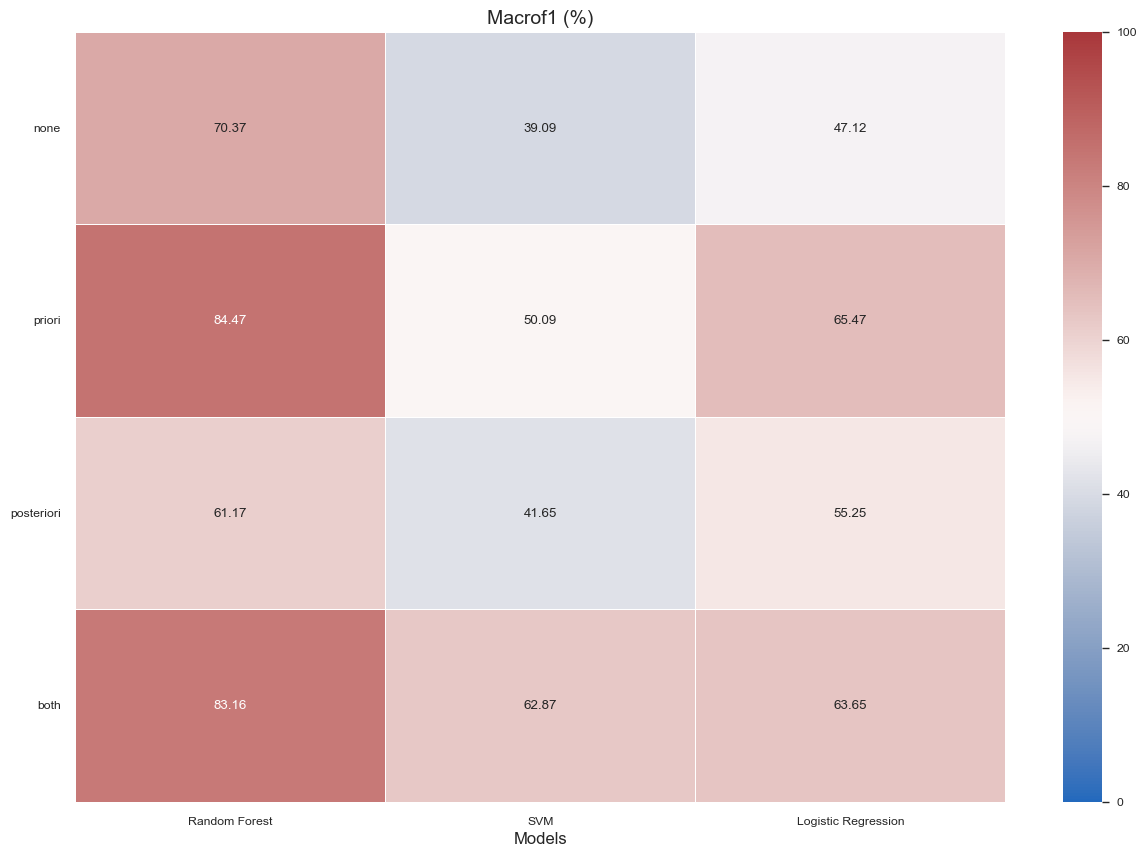

In [48]:
result_df = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(result_df.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f",vmax=100,vmin=0,linewidths=0.5)
#plt.title("Accuracy (%)", fontsize=14)
plt.title("Macrof1 (%)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.yticks(rotation=0)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'none'),
  Text(0, 1.5, 'priori'),
  Text(0, 2.5, 'posteriori'),
  Text(0, 3.5, 'both')])

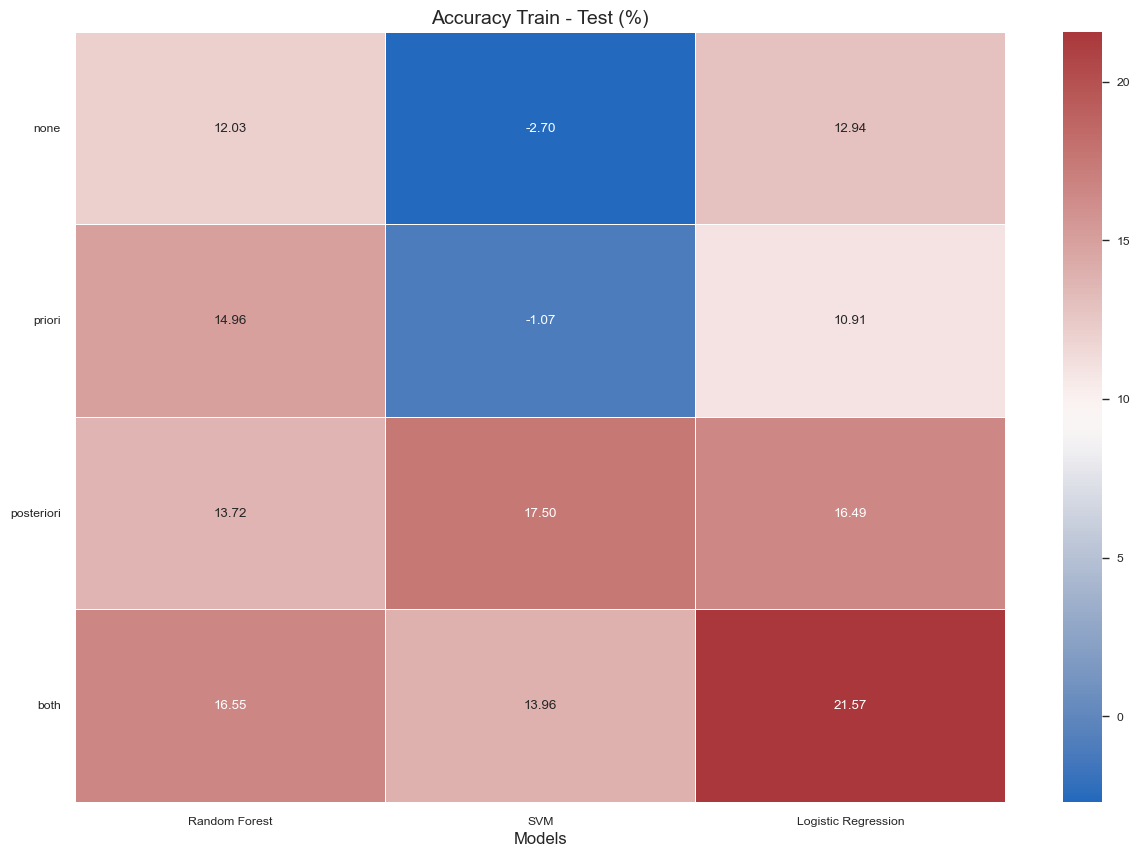

In [41]:
RESULT_NAME = "results_balancing_comparison_train.csv"
result_df_train = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

RESULT_NAME = "results_balancing_comparison_test.csv"
result_df_test = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

# difference
result_df = result_df_train - result_df_test

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(result_df.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f",linewidths=0.5)
plt.title("Accuracy Train - Test (%)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.yticks(rotation=0)